### Workflow 

#### Step 1 

##### [x] Study APIs from all data sources 
##### [x] Download data 

#### Step 2 

##### [x] Define data integration parameters 
##### [x] Define data structure 

#### Step 3  

#####  Integrate data 
#####  [x] ARPA + ERA5
#####  [x] (ARPA + ERA5) + Sentinel 5p

#### Step 4 

##### [] Generate statistical report to verify data integrity 



# LIBRARIES SET UP

In [1]:
'''In case you encounter the error: 
"CRSError: Invalid projection: EPSG:4326: (Internal Proj Error: proj_create: no database context specified)"
Uncomment and run the following code; then, continue.'''


import os
import pyproj

proj_path = r"C:\Users\Administrador\anaconda3\envs\cmcc_env\Library\share\proj"

# Force pyproj to use PROJ db
os.environ["PROJ_LIB"] = proj_path
pyproj.datadir.set_data_dir(proj_path)

print("PROJ path set in:", pyproj.datadir.get_data_dir())


PROJ path set in: C:\Users\Administrador\anaconda3\envs\cmcc_env\Library\share\proj


C:\Users\Administrador\anaconda3\envs\cmcc_env\lib\site-packages\pyproj\network.py:59: UserWarning: pyproj unable to set PROJ database path.
  _set_context_ca_bundle_path(ca_bundle_path)


In [2]:
import geopandas as gpd
import pandas as pd
import numpy as np
import unicodedata, re
from shapely.geometry import box, Point

# For Sentinel-5P access

import ee
import geemap.core as geemap

ee.Authenticate()
ee.Initialize(project='ee-saudisis') # project='ProjectID'Change to your ProjectID

import geemap
import xarray as xr # to read .nc

from datetime import timedelta
from datetime import datetime
import time
from tqdm import tqdm  # for progress bar visualization

import requests
from pathlib import Path

from scipy.spatial import distance_matrix # for grid creation

# Buttons
import ipywidgets as widgets
from IPython.display import display

# APIs
import requests
from sodapy import Socrata
from ddsapi import Client  # For CMCC DDS
import cdsapi

import glob


# CONFIGURATION SET UP

In [3]:
cfg = {
    "bbox": [8.9, 45.3, 9.6, 45.7],      # [min lon, min lat, max lon, max lat]
    "crs_grid": "EPSG:32632",            # local UTM zone 32N
    "crs_gee": "EPSG:4326",              # GEE expects WGS84
    "sentinel_scale_km": 5.5,            # Sentinel scale in km
    "arpa_resolution_deg": 0.005,        # ARPA grid ~500m
    "start_date": None,
    "end_date": None,
    "time_windows": {
        "prev": ("15:01", "11:59"),
        "curr": ("12:00", "15:00")
    }
}

def filter_curr(df, date):
    start = pd.to_datetime(f"{date} 12:00:00")
    end = pd.to_datetime(f"{date} 15:00:00")
    return df[(df["data"] >= start) & (df["data"] <= end)]

def filter_prev(df, date):
    day_before = pd.to_datetime(date) - pd.Timedelta(days=1)
    start = pd.to_datetime(f"{day_before.date()} 15:01:00")
    end = pd.to_datetime(f"{date} 11:59:00")
    return df[(df["data"] >= start) & (df["data"] <= end)]


# AOI as GeoDataFrame - BOUNDING BOX
minx, miny, maxx, maxy = cfg["bbox"]
aoi = gpd.GeoDataFrame(
    {"id": [1]},
    geometry=[box(minx, miny, maxx, maxy)],
    crs=cfg["crs_gee"])
aoi_utm = aoi.to_crs(cfg["crs_grid"])
aoi_gee = ee.Geometry.Rectangle([minx, miny, maxx, maxy])

#print("AOI in WGS84:", aoi)
#print("AOI in UTM:", aoi_utm)
#print("AOI for GEE:", aoi_gee.getInfo()["coordinates"])

In [4]:
start_date_widget = widgets.DatePicker(description="Start Date:")
end_date_widget = widgets.DatePicker(description="End Date:")
save_button = widgets.Button(description="Save Dates", button_style="success")
output_range = widgets.Output()

display(start_date_widget, end_date_widget, save_button, output_range)

def save_dates(b):
    with output_range:
        output_range.clear_output()

        # Save in global variables and cfg
        global start_date, end_date
        start_date = pd.to_datetime(start_date_widget.value)
        end_date = pd.to_datetime(end_date_widget.value)

        cfg["start_date"] = start_date
        cfg["end_date"] = end_date

        print(f" Dates have been saved:")
        print(f" Start: {start_date.date()}")
        print(f" End: {end_date.date()}")
        print(f" Please, continue")
        
save_button.on_click(save_dates)

DatePicker(value=None, description='Start Date:', step=1)

DatePicker(value=None, description='End Date:', step=1)

Button(button_style='success', description='Save Dates', style=ButtonStyle())

Output()

In [6]:
# Date Range Definition
if cfg["start_date"] is not None and cfg["end_date"] is not None:
    dates = pd.date_range(cfg["start_date"], cfg["end_date"], freq="D")
    print("Dates:", dates[:10], "...")
else:
    print("Date Range not yet defined.")

dates = pd.date_range(cfg["start_date"], cfg["end_date"], freq="D")
print("Process through", [d.date() for d in dates])

Dates: DatetimeIndex(['2025-06-01', '2025-06-02', '2025-06-03', '2025-06-04',
               '2025-06-05', '2025-06-06', '2025-06-07', '2025-06-08'],
              dtype='datetime64[ns]', freq='D') ...
Process through [datetime.date(2025, 6, 1), datetime.date(2025, 6, 2), datetime.date(2025, 6, 3), datetime.date(2025, 6, 4), datetime.date(2025, 6, 5), datetime.date(2025, 6, 6), datetime.date(2025, 6, 7), datetime.date(2025, 6, 8)]


# ARPA

##### In order to download ARPA data, you must have an account at: https://www.dati.lombardia.it/login 
##### Once you register, you will have access to an App Token that can be found here: https://www.dati.lombardia.it/profile/edit/developer_settings
##### Please copy your token for the app_token variable.
##### *Note: ARPAs' creation date was novemeber 20, 2017. Data prior to that date is not available. 

In [7]:
# ARPA access configuration
app_token = "vgiEMaAWkrTroWwi42G71LlIS"
headers = {"X-App-Token": app_token}
data_url = "https://www.dati.lombardia.it/resource/nicp-bhqi.json"
meta_url = "https://www.dati.lombardia.it/resource/ib47-atvt.csv?$limit=50000"

# 1. METADATA: Sensors and Coordinates
meta = (
    pd.read_csv(meta_url)
    .dropna(subset=["idsensore", "nometiposensore", "lat", "lng", "provincia"])
    .assign(
        idsensore=lambda df: df["idsensore"].astype(int),
        provincia=lambda df: df["provincia"].str.upper()
    )
)
provinces = sorted(meta["provincia"].unique())
pollutants = sorted(meta["nometiposensore"].unique())

# 2. USER INPUT for Data Download
province = widgets.Dropdown(options=provinces, description="Province:")
pollutant = widgets.Dropdown(options=pollutants, description="Pollutant:")
display(province, pollutant)

# 3. Download Data
def download_data(province, pollutant):
    meta_f = meta[
        (meta["provincia"] == province.upper()) &
        (meta["nometiposensore"] == pollutant)
    ]
    if meta_f.empty:
        print(f"No sensors for '{pollutant}' in '{province}'")
        return None
    print(f"\nSensors found in {province} for {pollutant}: {len(meta_f)}.")
    print(f"\nPlease wait until message of complete succesfull download appears, only then, click Analyze.")

    ids = meta_f["idsensore"].tolist()
    all_data = []

    if cfg["start_date"] is None or cfg["end_date"] is None:
        print("Please define start_date and end_date before downloading.")
        return None

    # Iterate through date range
    for date_analysis in pd.date_range(cfg["start_date"], cfg["end_date"], freq="D"):
        y, m, d = date_analysis.year, date_analysis.month, date_analysis.day
        print(f"\nDownloading data: {pollutant} ({province}) for {date_analysis.date()}")

        params = {
            "$select": "idsensore,data,valore",
            "$where": f"date_extract_y(data)={y} AND date_extract_m(data)={m} AND date_extract_d(data)={d}",
            "$limit": 50000
        }

        #  Try both ARPA endpoints sequentially 
        urls_to_try = [
            "https://www.dati.lombardia.it/resource/nicp-bhqi.json",  # main
            "https://www.dati.lombardia.it/resource/g2hp-ar79.json"   # fallback
        ]

        data = pd.DataFrame()
        for url in urls_to_try:
            try:
                print(f"→ Trying source: {url.split('/')[-1]} ...")
                r = requests.get(url, headers=headers, params=params)
                r.raise_for_status()
                temp = pd.DataFrame(r.json())
                if not temp.empty:
                    data = temp
                    print(f"Data found in {url.split('/')[-1]} ({len(data)} records)")
                    break
                else:
                    print("No data in this source, trying next")
            except Exception as e:
                print(f"Error with {url.split('/')[-1]}: {e}")

        if data.empty:
            print("No information available for this date in any source.")
            continue

        # Convert types
        data["idsensore"] = pd.to_numeric(data["idsensore"], errors="coerce").astype("Int64")
        data["data"] = pd.to_datetime(data["data"], errors="coerce")
        data["valore"] = pd.to_numeric(data["valore"], errors="coerce")
        data = data[data["idsensore"].isin(ids)]

        # Merge ARPA with its METADATA
        merged = data.merge(meta_f, on="idsensore", how="inner")
        merged = merged.rename(columns={"nometiposensore": "pollutant", "valore": "value"})
        merged = merged[["idsensore", "pollutant", "data", "value", "lat", "lng", "provincia"]]
        merged["date"] = date_analysis.date()

        all_data.append(merged)
        print(f"{len(merged)} records downloaded for {date_analysis.date()}")

    if all_data:
        merged_all = pd.concat(all_data, ignore_index=True)
        print(f"\nCombined {len(all_data)} days of data ({cfg['start_date'].date()} - {cfg['end_date'].date()})")
        return merged_all
    else:
        print("No data downloaded in the selected range.")
        return None


        # Convert types
        data["idsensore"] = pd.to_numeric(data["idsensore"], errors="coerce").astype("Int64")
        data["data"] = pd.to_datetime(data["data"], errors="coerce")
        data["valore"] = pd.to_numeric(data["valore"], errors="coerce")
        data = data[data["idsensore"].isin(ids)]

        # Merge ARPA with its METADATA
        merged = data.merge(meta_f, on="idsensore", how="inner")
        merged = merged.rename(columns={"nometiposensore": "pollutant", "valore": "value"})
        merged = merged[["idsensore", "pollutant", "data", "value", "lat", "lng", "provincia"]]
        merged["date"] = date_analysis.date()

        all_data.append(merged)
        print(f"{len(merged)} records downloaded for {date_analysis.date()}")

    if all_data:
        merged_all = pd.concat(all_data, ignore_index=True)
        print(f"\nCombined {len(all_data)} days of data ({cfg['start_date'].date()} - {cfg['end_date'].date()})")
        return merged_all
    else:
        print("No data downloaded in the selected range.")
        return None


# 4. Processing of the Data
def analyze_data(merged, pollutant, province):
    if merged is None or merged.empty:
        print("No data to analyze.")
        return None

    if cfg["start_date"] is None or cfg["end_date"] is None:
        print("Date range hasn't been defined.")
        return None

    all_summaries = []

    for date_analysis in pd.date_range(cfg["start_date"], cfg["end_date"], freq="D"):
        prev_date = date_analysis - pd.Timedelta(days=1)
        subset = merged[merged["data"].dt.date.isin([prev_date.date(), date_analysis.date()])].copy()

        if subset.empty:
            print(f"No data for {date_analysis.date()}")
            continue

        subset["hour"] = subset["data"].dt.hour

        def classify_period(row):
            date, hour = row["data"].date(), row["hour"]
            if date == date_analysis.date() and 12 <= hour < 15:
                return "current"
            elif (date == prev_date.date() and hour >= 15) or (date == date_analysis.date() and hour < 12):
                return "previous"
            else:
                return None

        subset["period"] = subset.apply(classify_period, axis=1)
        subset = subset.dropna(subset=["period"])

        # Mean Computation
        summary = (
            subset.groupby(["idsensore", "lat", "lng", "provincia", "period"])["value"]
            .mean()
            .reset_index()
            .pivot(index=["idsensore", "lat", "lng", "provincia"],
                   columns="period",
                   values="value")
            .reset_index()
            .rename(columns={"current": "curr_mean", "previous": "prev_mean"})
        )

        summary["pollutant"] = pollutant
        summary["date"] = date_analysis.date()
        all_summaries.append(summary)
        print(f"Date analyzed: {date_analysis.date()} — Province: {province} — Pollutant: {pollutant}")

    if all_summaries:
        summary_all = pd.concat(all_summaries, ignore_index=True)
        print(f"\nAnalysis completed for {len(all_summaries)} days ({cfg['start_date'].date()} → {cfg['end_date'].date()})")
        display(summary_all.head())
        return summary_all
    else:
        print("No summaries generated.")
        return None


# 5. Interface
button_download = widgets.Button(description="Download Data", button_style="success")
button_analyze = widgets.Button(description="Analyze", button_style="info")
output = widgets.Output()

state = {"merged": None, "province": None, "pollutant": None}


def on_download(b):
    with output:
        output.clear_output()
        state["province"] = province.value
        state["pollutant"] = pollutant.value

        merged = download_data(state["province"], state["pollutant"])
        state["merged"] = merged

        # Save filtered metadata
        state["meta_f"] = meta[
            (meta["provincia"].str.upper() == state["province"].upper()) &
            (meta["nometiposensore"] == state["pollutant"])
        ]

        if merged is not None and not merged.empty:
            print("\nData and metadata loaded successfully. Click Analyze to proceed")
        else:
            print("No data was downloaded. Retry.")

def on_analyze(b):
    with output:
        output.clear_output()
        gdf = analyze_data(state["merged"], state["pollutant"], state["province"])
        if gdf is not None:
            state["summary"] = gdf
            print("GeoDataFrame created successfully. You can continue")

button_download.on_click(on_download)
button_analyze.on_click(on_analyze)
print (f"\nFIRST: Choose the Province and Pollutant of Interest and click Download Data\n")
display(button_download, button_analyze, output)



Dropdown(description='Province:', options=('BG', 'BS', 'CO', 'CR', 'LC', 'LO', 'MB', 'MI', 'MN', 'NO', 'PV', '…

Dropdown(description='Pollutant:', options=('Ammoniaca', 'Arsenico', 'Benzene', 'Benzo(a)pirene', 'Biossido di…


FIRST: Choose the Province and Pollutant of Interest and click Download Data



Button(button_style='success', description='Download Data', style=ButtonStyle())

Button(button_style='info', description='Analyze', style=ButtonStyle())

Output()

In [8]:
# ARPA Grid
def build_grid(meta_f, pollutant):
    # Sensors GeoDataFrame
    sensors_gdf = gpd.GeoDataFrame(
        meta_f, geometry=gpd.points_from_xy(meta_f["lng"], meta_f["lat"]), crs="EPSG:4326")
    # Distance matrix
    coords = np.array(list(zip(sensors_gdf.geometry.x, sensors_gdf.geometry.y)))
    dist_mat = distance_matrix(coords, coords)
    
# No zero distance 
    dist_mat[dist_mat == 0] = np.nan

# Minimum Distance Computation
    min_dist_deg = np.nanmin(dist_mat)   

    if np.isnan(min_dist_deg) or min_dist_deg == 0:
        print("Cannot compute grid: only one sensor or identical coordinates.")
        return None

    print(f"\nMinimum distance between sensors ({pollutant}): {min_dist_deg:.6f} degrees")

    # Grid resolution - slightly greater than the min distance so that there're no issues when adding the information with ERA5
    res = min_dist_deg * 0.9  # 90% denser grid
   
    # Grid Creation inside sensors bbox
    minx, miny, maxx, maxy = sensors_gdf.total_bounds

    xs = np.arange(minx, maxx, res)
    ys = np.arange(miny, maxy, res)

    grid_points = [Point(x, y) for x in xs for y in ys]
    grid_gdf = gpd.GeoDataFrame(
        {"grid_id": range(len(grid_points))},
        geometry=grid_points,
        crs="EPSG:4326"
    )

    print(f"\nGrid: {len(grid_gdf)} points — resolution ≈ {res:.6f}°")
    display(grid_gdf.head())
    return grid_gdf

meta_f = state["meta_f"]
pollutant_name = state["pollutant"]

print(meta_f[["idsensore", "nometiposensore", "lat", "lng"]])
print(len(meta_f))

# Build grid
grid_gdf = build_grid(meta_f, pollutant_name)

# Save in state for later ERA5 use
state["grid_gdf"] = grid_gdf


     idsensore  nometiposensore        lat       lng
19        6302  Ossidi di Azoto  45.436113  9.097412
47        6308  Ossidi di Azoto  45.571720  9.078245
109       6364  Ossidi di Azoto  45.526556  8.736502
123       6298  Ossidi di Azoto  45.552328  9.227766
155       6324  Ossidi di Azoto  45.483632  9.327362
171       6288  Ossidi di Azoto  45.548521  8.847327
177       6290  Ossidi di Azoto  45.543437  9.080729
180       6362  Ossidi di Azoto  45.405549  9.370992
227       6358  Ossidi di Azoto  45.480272  9.056864
229       6360  Ossidi di Azoto  45.613700  9.508134
261       6366  Ossidi di Azoto  45.463349  9.195325
350       6372  Ossidi di Azoto  45.476065  9.141787
358       6338  Ossidi di Azoto  45.281964  8.988576
434       6284  Ossidi di Azoto  45.395410  8.913418
438       6328  Ossidi di Azoto  45.496319  9.190934
449       6318  Ossidi di Azoto  45.595389  8.922039
494       6350  Ossidi di Azoto  45.517827  8.766567
497       6346  Ossidi di Azoto  45.523429  9.

,grid_id,geometry
0,0,POINT (8.7365 45.28196)
1,1,POINT (8.7365 45.28868)
2,2,POINT (8.7365 45.2954)
3,3,POINT (8.7365 45.30212)
4,4,POINT (8.7365 45.30883)


# ERA5

## ACCESS TO ERA5

##### Before accessing ERA5, please read and setup de CDSAPI.
##### You can follow the instructions from this webpage: https://cds.climate.copernicus.eu/how-to-api

### API fetch

In [9]:
for f in glob.glob("era5_data/*.nc"):
    os.remove(f)
print("Remove previous files if settings were modified. Now the folder is ready for new downloads.")

def download_era5_from_cfg(cfg):
    client = cdsapi.Client()
    os.makedirs("era5_data", exist_ok=True)

    start_date = pd.to_datetime(cfg["start_date"])
    end_date = pd.to_datetime(cfg["end_date"])

    bbox = [7, 44, 10, 48]  # [min lon, min lat, max lon, max lat]
    area = [bbox[3], bbox[0], bbox[1], bbox[2]]  # [N, W, S, E]

    variables = [
        "2m_temperature",
        "surface_net_solar_radiation",
        "surface_net_thermal_radiation",
        "surface_pressure",
        "total_precipitation",
        "10m_u_component_of_wind",
        "10m_v_component_of_wind",
        "boundary_layer_height"
    ]

    for var in variables:
        out_file = f"era5_data/{var}_{start_date.date()}_{end_date.date()}.nc"
        if os.path.exists(out_file):
            print(f" {var} Already exists, download is omitted.")
            continue

        try:
            print(f" Downloading {var} ({start_date.date()} - {end_date.date()})...")
            client.retrieve(
                "reanalysis-era5-single-levels",
                {
                    "product_type": "reanalysis",
                    "format": "netcdf",
                    "variable": [var],
                    "date": f"{start_date.date()}/{end_date.date()}",
                    "time": [f"{h:02d}:00" for h in range(24)],
                    "area": area
                },
                out_file
            )
            print(f"Saved: {out_file}")
        except Exception as e:
            print(f"Error in download {var}: {e}")

    print("\n Completed download. All files have been saved in /era5_data/")

download_era5_from_cfg(cfg)


Remove previous files if settings were modified. Now the folder is ready for new downloads.


2025-10-27 23:39:37,939 INFO Request ID is aec60c46-2c69-4efc-bba0-e6ebb5318f09
2025-10-27 23:39:38,041 INFO status has been updated to accepted
2025-10-27 23:39:46,643 INFO status has been updated to running
2025-10-27 23:39:59,397 INFO status has been updated to successful


8e415c30db46bf30a8d3277c4378f207.nc:   0%|          | 0.00/106k [00:00<?, ?B/s]

Saved: era5_data/2m_temperature_2025-06-01_2025-06-08.nc


2025-10-27 23:40:00,660 INFO Request ID is fe90c060-1fb8-4adb-a4c8-985c470a4fb5
2025-10-27 23:40:00,765 INFO status has been updated to accepted
2025-10-27 23:40:14,497 INFO status has been updated to running
2025-10-27 23:40:50,842 INFO status has been updated to successful


cf405aa13296de892219823ffaf81a74.nc:   0%|          | 0.00/89.2k [00:00<?, ?B/s]

Saved: era5_data/surface_net_solar_radiation_2025-06-01_2025-06-08.nc


2025-10-27 23:40:51,669 INFO Request ID is c749ca43-2a72-4298-8069-8237ddc8e8aa
2025-10-27 23:40:51,771 INFO status has been updated to accepted
2025-10-27 23:41:00,271 INFO status has been updated to running
2025-10-27 23:41:24,643 INFO status has been updated to successful


ea449737e076f523779b0946fb2a561f.nc:   0%|          | 0.00/132k [00:00<?, ?B/s]

Saved: era5_data/surface_net_thermal_radiation_2025-06-01_2025-06-08.nc


2025-10-27 23:41:25,666 INFO Request ID is 5da87b0b-34b4-4b1f-ab9f-5fbc8f2307a5
2025-10-27 23:41:25,763 INFO status has been updated to accepted
2025-10-27 23:41:39,594 INFO status has been updated to running
2025-10-27 23:41:58,743 INFO status has been updated to successful


d31732326984a3805928c8c6c2959289.nc:   0%|          | 0.00/93.0k [00:00<?, ?B/s]

Saved: era5_data/surface_pressure_2025-06-01_2025-06-08.nc


2025-10-27 23:41:59,444 INFO Request ID is f466b025-946c-4437-92dd-2338532e3827
2025-10-27 23:41:59,551 INFO status has been updated to accepted
2025-10-27 23:42:32,332 INFO status has been updated to successful


52682f243ba0e7827cafe183fd322ac7.nc:   0%|          | 0.00/94.2k [00:00<?, ?B/s]

Saved: era5_data/total_precipitation_2025-06-01_2025-06-08.nc


2025-10-27 23:42:33,262 INFO Request ID is 06057feb-74f7-4e63-8429-66622190151d
2025-10-27 23:42:33,360 INFO status has been updated to accepted
2025-10-27 23:42:41,955 INFO status has been updated to running
2025-10-27 23:42:54,753 INFO status has been updated to successful


a935454c6a3c35736c8204e6f727b26.nc:   0%|          | 0.00/134k [00:00<?, ?B/s]

Saved: era5_data/10m_u_component_of_wind_2025-06-01_2025-06-08.nc


2025-10-27 23:42:55,783 INFO Request ID is 02e366f7-79db-40aa-a6ce-15efbce3c1ee
2025-10-27 23:42:55,884 INFO status has been updated to accepted
2025-10-27 23:43:09,721 INFO status has been updated to running
2025-10-27 23:43:29,266 INFO status has been updated to successful


8c545528e3c33cc2e87123f725ea7fef.nc:   0%|          | 0.00/133k [00:00<?, ?B/s]

Saved: era5_data/10m_v_component_of_wind_2025-06-01_2025-06-08.nc


2025-10-27 23:43:30,598 INFO Request ID is 36fe7d97-79a7-41f6-bb75-c9d3f3c771a6
2025-10-27 23:43:30,699 INFO status has been updated to accepted
2025-10-27 23:43:39,201 INFO status has been updated to running
2025-10-27 23:44:20,729 INFO status has been updated to successful


909eb53d6d56d11a5fc3df89dde5b505.nc:   0%|          | 0.00/135k [00:00<?, ?B/s]

Saved: era5_data/boundary_layer_height_2025-06-01_2025-06-08.nc

 Completed download. All files have been saved in /era5_data/


### One dataset with all variables:

In [10]:
# Merge all .nc files into one data set
folder = "era5_data"
files = sorted(glob.glob(os.path.join(folder, "*.nc")))
datasets = [xr.open_dataset(f) for f in files]
merged_xr = xr.merge(datasets)   # xarray copy if future need

# Convert to Dataframe
ds_merged = merged_xr.to_dataframe().reset_index()

print("Merged Dataset")
display(ds_merged.head())

Merged Dataset


,valid_time,latitude,longitude,number,expver,u10,v10,t2m,blh,ssr,str,sp,tp
0,2025-06-01,48.0,7.00,0,0001,0.977097,2.237000,290.674561,158.644012,3.599999e-12,-155913.125,95513.3125,0.000014
1,2025-06-01,48.0,7.25,0,0001,1.204636,2.331726,290.735107,138.144012,3.599999e-12,-157321.125,96657.3125,0.000000
2,2025-06-01,48.0,7.50,0,0001,0.482956,2.759460,291.260498,128.144012,3.599999e-12,-165993.125,98208.3125,0.000000
3,2025-06-01,48.0,7.75,0,0001,0.150925,2.892273,290.934326,113.269020,3.599999e-12,-165705.125,96739.3125,0.000000
4,2025-06-01,48.0,8.00,0,0001,-0.131302,2.854187,290.104248,100.644020,3.599999e-12,-159177.125,94099.3125,0.000000


### Units Conversion

In [11]:
# Units Conversion

# Temperature from [K to °C]
if "t2m" in ds_merged:
    ds_merged["t2m_c"] = ds_merged["t2m"] - 273.15

# Pressure from [Pa to hPa]
if "sp" in ds_merged:
    ds_merged["sp_hpa"] = ds_merged["sp"] / 100.0

# Surface Solar Radiation from [J to kJ]
if "ssr" in ds_merged:
    ds_merged["ssr_kJ"] = ds_merged["ssr"] / 1000.0

# Surface Thermal Radiation from [J to kJ]
if "str" in ds_merged:
    ds_merged["str_kJ"] = ds_merged["str"] / 1000.0

# Boundary Layer Height [m to km]
if "blh" in ds_merged:
    ds_merged["blh_km"] = ds_merged["blh"] / 1000.0

# Total windspeed computation [m/s] (using u10 and v10)
if all(v in ds_merged for v in ["u10", "v10"]):
    ds_merged["wind_speed"] = np.sqrt(ds_merged["u10"]**2 + ds_merged["v10"]**2)

#display(ds_merged.head(20))

### Grid Alignment for future interpolation

In [12]:
# Grid alignment

grid_wgs84 = grid_gdf.to_crs("EPSG:4326")
grid_wgs84["lat"] = grid_wgs84.geometry.y
grid_wgs84["lon"] = grid_wgs84.geometry.x

### ERA5 + ARPA variables interpolation process

In [13]:
# Interpolated variables to join with ARPA

# DataFrame to xarray Dataset
ds_xr = ds_merged.set_index(["valid_time", "latitude", "longitude"]).to_xarray()

vars_era5 = ["t2m_c", "sp_hpa", "wind_speed", "blh_km", "tp", "ssr_kJ", "str_kJ"]
results = []

for t in tqdm(ds_xr["valid_time"].values, desc="Interpolating ERA5 on ARPA grid"):
    ds_hour = ds_xr.sel(valid_time=t)

    # Bilinear interpolation on the grid
    interp = ds_hour[vars_era5].interp(
        latitude=("points", grid_wgs84["lat"]),
        longitude=("points", grid_wgs84["lon"])
    )

# To DataFrame
    interp_df = interp.to_dataframe().reset_index(drop=True)
    interp_df["valid_time"] = pd.to_datetime(t)

# Grid Coordinates 
    interp_df["grid_id"] = grid_wgs84["grid_id"]
    interp_df["lat"] = grid_wgs84["lat"]
    interp_df["lon"] = grid_wgs84["lon"]
    
    results.append(interp_df)

# Concatenate
era5_on_arpa = pd.concat(results, ignore_index=True)

#print(era5_on_arpa.head())
print(f"\nConcatenated number of rows: {len(era5_on_arpa)}")

Interpolating ERA5 on ARPA grid: 100%|███████████████████████████████████████████████| 192/192 [00:03<00:00, 58.90it/s]



Concatenated number of rows: 1123200


### ERA5 mean computation

In [14]:
# 1. ERA5 cleaning
era5_df = era5_on_arpa.drop(columns=["lat", "lon"], errors="ignore").copy()

# 2. Period time defined in cfg
def assign_period(df, date):
    curr_start = pd.to_datetime(f"{date} {cfg['time_windows']['curr'][0]}")
    curr_end   = pd.to_datetime(f"{date} {cfg['time_windows']['curr'][1]}")
    prev_start = pd.to_datetime(f"{(pd.to_datetime(date) - pd.Timedelta(days=1)).date()} {cfg['time_windows']['prev'][0]}")
    prev_end   = pd.to_datetime(f"{date} {cfg['time_windows']['prev'][1]}")

    def classify(ts):
        if curr_start <= ts <= curr_end:
            return "current"
        elif prev_start <= ts <= prev_end:
            return "previous"
        else:
            return None

    df["period"] = df["valid_time"].apply(classify)
    return df.dropna(subset=["period"])
    

for date_analysis in pd.date_range(cfg["start_date"], cfg["end_date"], freq="D"):
    print(f"\nProcessing ERA5 for {date_analysis.date()}")
    era5_df_day = assign_period(era5_df, date_analysis.date())

    era5_summary = (
        era5_df_day.groupby(["grid_id", "period"], as_index=False)
        .mean(numeric_only=True)
        .pivot(index="grid_id", columns="period")
        .reset_index()
    )
    print(f"\nGenerated rows for {date_analysis.date()}: {len(era5_summary)}")

# 3. Mean Computation
era5_summary = (
    era5_df.groupby(["grid_id", "period"], as_index=False)
    .mean(numeric_only=True)
    .pivot(index="grid_id", columns="period")
    .reset_index()
)

# Flatten MultiIndex
era5_summary.columns = [
    "_".join([str(c) for c in col if c not in ("", None)]).strip("_")
    if isinstance(col, tuple) else str(col)
    for col in era5_summary.columns
]

# 4. Removal of redundant coordinate columns
era5_summary = era5_summary.loc[:, ~era5_summary.columns.str.contains("lat|lon|latitude|longitude", case=False)]
era5_summary = era5_summary.drop(columns=["number_current", "number_previous"], errors="ignore")

# 5. Merge with grid coordinates
era5_summary = era5_summary.merge(
    grid_wgs84[["grid_id", "lat", "lon"]],
    on="grid_id",
    how="left"
)

# 6. Reordering for readability
ordered_cols = ["grid_id", "lat", "lon"] + sorted(
    [c for c in era5_summary.columns if any(x in c for x in ["_current", "_previous"])]
)
era5_summary = era5_summary[ordered_cols]

# Summary preview 
print(f"\nERA5 summary for {date_analysis.date()} ({pollutant.value}, {province.value})\n")
display(era5_summary.filter(regex="t2m|sp|wind|ssr|str|blh|tp|lat|lon").head())


Processing ERA5 for 2025-06-01

Generated rows for 2025-06-01: 5850

Processing ERA5 for 2025-06-02

Generated rows for 2025-06-02: 5850

Processing ERA5 for 2025-06-03

Generated rows for 2025-06-03: 5850

Processing ERA5 for 2025-06-04

Generated rows for 2025-06-04: 5850

Processing ERA5 for 2025-06-05

Generated rows for 2025-06-05: 5850

Processing ERA5 for 2025-06-06

Generated rows for 2025-06-06: 5850

Processing ERA5 for 2025-06-07

Generated rows for 2025-06-07: 5850

Processing ERA5 for 2025-06-08

Generated rows for 2025-06-08: 5850

ERA5 summary for 2025-06-08 (Ossidi di Azoto, MI)



,lat,lon,blh_km_current,blh_km_previous,sp_hpa_current,sp_hpa_previous,ssr_kJ_current,ssr_kJ_previous,str_kJ_current,str_kJ_previous,t2m_c_current,t2m_c_previous,tp_current,tp_previous,wind_speed_current,wind_speed_previous
0,45.281964,8.736502,1.125201,0.422060,997.153475,997.842629,2269.318466,433.826823,-368.042493,-158.793853,29.039616,22.257788,0.000007,0.000019,2.506242,1.844463
1,45.288681,8.736502,1.122491,0.419041,996.872010,997.556735,2271.604372,433.692498,-368.252444,-158.217110,29.017374,22.236077,0.000007,0.000020,2.480543,1.824397
2,45.295399,8.736502,1.119781,0.416021,996.590546,997.270840,2273.890277,433.558173,-368.462395,-157.640367,28.995132,22.214366,0.000007,0.000021,2.454844,1.804330
3,45.302117,8.736502,1.117071,0.413002,996.309082,996.984946,2276.176183,433.423848,-368.672346,-157.063624,28.972890,22.192655,0.000008,0.000022,2.429146,1.784264
4,45.308835,8.736502,1.114361,0.409982,996.027618,996.699052,2278.462088,433.289523,-368.882297,-156.486882,28.950648,22.170944,0.000008,0.000023,2.403447,1.764198


# ARPA + ERA5

In [15]:
# ERA5 summary to GeoDataFrame
summary = state["summary"]
era5_gdf = gpd.GeoDataFrame(
    era5_summary,
    geometry=gpd.points_from_xy(era5_summary["lon"], era5_summary["lat"]), 
    crs="EPSG:4326"
).to_crs("EPSG:32632")

# ARPA sensors (summary) to GeoDataFrame
summary_gdf = gpd.GeoDataFrame(
    summary,
    geometry=gpd.points_from_xy(summary["lng"], summary["lat"]),
    crs="EPSG:4326"
).to_crs("EPSG:32632")

# Search nearest ARPA sensor to ERA5 variable
era5_vars = [c for c in era5_summary.columns if "_current" in c or "_previous" in c]

for var in era5_vars:
    nearest_idx = era5_gdf.sindex.nearest(summary_gdf.geometry, return_all=False)[1]
    summary_gdf[var] = era5_gdf.iloc[nearest_idx][var].values

# New WGS84 
summary_gdf = summary_gdf.to_crs("EPSG:4326")

# ERA5 + ARPA
print(f"\nARPA sensors enriched with ERA5 variables for {state['pollutant']}"
      f"from {cfg['start_date'].date()} to {cfg['end_date'].date()} "
      f"in {state['province']}\nDataset contains {len(summary_gdf)} registers\n")
display(summary_gdf.head(10))
summary_gdf["date"].value_counts().sort_index()


ARPA sensors enriched with ERA5 variables for Ossidi di Azotofrom 2025-06-01 to 2025-06-08 in MI
Dataset contains 120 registers



period,idsensore,lat,lng,provincia,curr_mean,prev_mean,pollutant,date,geometry,blh_km_current,...,ssr_kJ_current,ssr_kJ_previous,str_kJ_current,str_kJ_previous,t2m_c_current,t2m_c_previous,tp_current,tp_previous,wind_speed_current,wind_speed_previous
0,6276,45.396198,9.282699,MI,18.433333,26.250000,Ossidi di Azoto,2025-06-01,POINT (9.2827 45.3962),1.177786,...,2084.041304,417.160405,-337.030282,-172.732683,29.438481,23.326060,0.000006,0.000015,2.004210,1.386588
1,6288,45.548521,8.847327,MI,6.000000,15.333333,Ossidi di Azoto,2025-06-01,POINT (8.84733 45.54852),1.033387,...,2306.964800,420.029075,-365.664971,-135.690235,28.269936,21.629554,0.000017,0.000092,1.548476,1.213138
2,6300,45.547597,9.166983,MI,13.366667,23.425000,Ossidi di Azoto,2025-06-01,POINT (9.16698 45.5476),1.072049,...,2168.375273,395.779545,-345.452585,-146.985999,28.633550,22.349484,0.000016,0.000068,1.733477,1.259149
3,6320,45.443860,9.167945,MI,12.700000,32.350000,Ossidi di Azoto,2025-06-01,POINT (9.16794 45.44386),1.139189,...,2133.773699,411.854974,-341.318897,-160.234734,29.216975,22.978763,0.000012,0.000031,1.876858,1.404927
4,6324,45.483632,9.327362,MI,7.166667,16.375000,Ossidi di Azoto,2025-06-01,POINT (9.32736 45.48363),1.128354,...,2097.359512,403.958601,-337.407088,-166.335726,29.141623,23.062826,0.000012,0.000020,2.038341,1.340018
5,6326,45.462421,8.880214,MI,5.100000,19.791667,Ossidi di Azoto,2025-06-01,POINT (8.88021 45.46242),1.086556,...,2263.923505,418.916552,-358.843451,-144.032726,28.712525,22.124429,0.000018,0.000045,1.778714,1.407702
6,6328,45.496319,9.190934,MI,32.366667,48.666667,Ossidi di Azoto,2025-06-01,POINT (9.19093 45.49632),1.112198,...,2139.668962,406.995365,-342.180579,-157.214438,29.122715,22.886711,0.000013,0.000033,1.808868,1.323954
7,6338,45.281964,8.988576,MI,9.233333,18.841667,Ossidi di Azoto,2025-06-01,POINT (8.98858 45.28196),1.199289,...,2148.281146,422.127612,-342.236557,-162.347731,29.369869,23.066098,0.000015,0.000033,2.236339,1.888904
8,6346,45.523429,9.044602,MI,10.566667,35.741667,Ossidi di Azoto,2025-06-01,POINT (9.0446 45.52343),1.085881,...,2205.045475,404.522413,-347.109262,-142.668082,28.716564,22.319846,0.000022,0.000059,1.662735,1.363808
9,6354,45.470501,9.197461,MI,13.133333,20.633333,Ossidi di Azoto,2025-06-01,POINT (9.19746 45.4705),1.127108,...,2129.105677,409.430980,-341.305503,-160.266171,29.202248,22.982798,0.000011,0.000029,1.851293,1.348106


date
2025-06-01    15
2025-06-02    15
2025-06-03    15
2025-06-04    15
2025-06-05    15
2025-06-06    15
2025-06-07    15
2025-06-08    15
Name: count, dtype: int64

# SENTINEL-5P

## Sentinel 5P PRECONFIGURATION

In [16]:
# Pollutant name mapping for Sentinel
def normalize_name(s: str) -> str:
    s = unicodedata.normalize("NFKD", str(s)).encode("ascii", "ignore").decode()
    return re.sub(r"[^a-z0-9]+", " ", s.lower()).strip()  

ALIASES = {
    "no2": {"no2", "diossido di azoto", "biossido di azoto", "dioxido de nitrogeno", "dióxido de nitrógeno", "nitrogen dioxide",
            "nitrogeno dioxido", "ossidi di azoto","NO2", "Diossido di Azoto", "Biossido di Azoto", "Dioxido de Nitrogeno", 
            "Dióxido de Nitrógeno", "Nitrogen Dioxide",
            "Nitrogeno Dioxido", "Ossidi di Azoto",},
    "co": {"co", "monossido di carbonio", "monoxido de carbono", "carbon monoxide",  "monossido de carbono", "carbonio monossido", 
           "monóxido de carbono", "CO", "Monossido di Carbonio", "Monoxido de Carbono", "Carbon Monoxide",  "Monossido de Carbono", 
           "Carbonio Monossido", "Monóxido de Carbono"},
    "o3": {"o3", "ozono", "ozone", "ozono troposferico", "ozono totale",
           "O3", "Ozono", "Ozone", "Ozono Troposferico", "Ozono Totale"},
    "so2": {"so2", "diossido di zolfo", "biossido di zolfo", "dioxido de azufre", "dióxido de azufre", "sulfur dioxide", "zolfo diossido",
           "SO2", "Diossido di Zolfo", "Biossido di Zolfo", "Dioxido de Azufre", "Dióxido de Azufre", "Sulfur Dioxide", "Zolfo Diossido"},
}

LOOKUP = {normalize_name(n): k for k, names in ALIASES.items() for n in names}

def get_pollutant_key(pollutant: str) -> str:
    k = LOOKUP.get(normalize_name(pollutant))
    if not k:
        raise ValueError(f"Unexistent pollutant '{pollutant}' for Sentinel-5P.")
    return k

## SENTINEL-5P IMAGE FETCH 

In [17]:
def extract_s5p_value(pollutant_key, aoi_gee, summary_gdf):
    pollutants = {
        "no2": {"collection": "COPERNICUS/S5P/OFFL/L3_NO2", "band": "NO2_column_number_density", "unit": "mol/m²", "scale": 5500},
        "co": {"collection": "COPERNICUS/S5P/OFFL/L3_CO", "band": "CO_column_number_density", "unit": "mol/m²", "scale": 5500},
        "o3": {"collection": "COPERNICUS/S5P/OFFL/L3_O3", "band": "O3_column_number_density", "unit": "mol/m²", "scale": 5500},
        "so2": {"collection": "COPERNICUS/S5P/OFFL/L3_SO2", "band": "SO2_column_number_density", "unit": "mol/m²", "scale": 5500},
    }

    cfg_pollutant = pollutants[pollutant_key]
    dataset_id = cfg_pollutant["collection"]
    band_name = cfg_pollutant["band"]

    all_results = []

    for date_analysis in pd.date_range(cfg["start_date"], cfg["end_date"], freq="D"):
        start_date = str(date_analysis.date())
        end_date = str((date_analysis + pd.Timedelta(days=1)).date())
        print(f"Extracting Sentinel-5P {pollutant_key.upper()} for {start_date}")
        
        # Sentinel 5p Images
        s5p = (
            ee.ImageCollection(dataset_id)
            .filterDate(start_date, end_date)
            .filterBounds(aoi_gee)
            .select(band_name)
            .mean()
        )

        df_day = summary_gdf[summary_gdf["date"] == pd.to_datetime(start_date).date()].copy()
        if df_day.empty:
            print(f"No ARPA data for {start_date}, skipping.")
            continue
        
        # ARPA points for extraction values
        def get_value(lon, lat):
            point = ee.Geometry.Point(lon, lat)
            value = s5p.reduceRegion(
                reducer=ee.Reducer.mean(),
                geometry=point,
                scale=cfg_pollutant["scale"],
            ).get(band_name)
            return value.getInfo()

        df_day[f"Sentinel 5P {pollutant_key.upper()} Concentration (mol/m²)"] = [
            get_value(lon, lat) for lon, lat in zip(df_day["lng"], df_day["lat"])
        ]
        df_day["Sentinel 5P Dataset"] = dataset_id
        df_day["Sentinel 5P Band"] = band_name
        df_day["Sentinel 5P Units"] = cfg_pollutant["unit"]
        df_day["Sentinel 5P Date"] = start_date

        all_results.append(df_day)

        # Current day results
        print(f"Day {start_date} processed — {len(df_day)} registers")
        display(df_day.head(3))

    if all_results:
        summary_with_s5p = pd.concat(all_results, ignore_index=True)
        print(f"\nSentinel Extraction Done — {len(all_results)} processed days.")
        print(f"   Dates: {cfg['start_date'].date()} → {cfg['end_date'].date()}")
        print(f"   Total registers: {len(summary_with_s5p)}")
        return summary_with_s5p
    else:
        print("No results generated")
        return summary_gdf

pollutant_key = get_pollutant_key(pollutant.value)
summary_with_s5p = extract_s5p_value(pollutant_key, aoi_gee, summary_gdf)


Extracting Sentinel-5P NO2 for 2025-06-01
Day 2025-06-01 processed — 15 registers


period,idsensore,lat,lng,provincia,curr_mean,prev_mean,pollutant,date,geometry,blh_km_current,...,t2m_c_previous,tp_current,tp_previous,wind_speed_current,wind_speed_previous,Sentinel 5P NO2 Concentration (mol/m²),Sentinel 5P Dataset,Sentinel 5P Band,Sentinel 5P Units,Sentinel 5P Date
0,6276,45.396198,9.282699,MI,18.433333,26.250000,Ossidi di Azoto,2025-06-01,POINT (9.2827 45.3962),1.177786,...,23.326060,0.000006,0.000015,2.004210,1.386588,0.000107,COPERNICUS/S5P/OFFL/L3_NO2,NO2_column_number_density,mol/m²,2025-06-01
1,6288,45.548521,8.847327,MI,6.000000,15.333333,Ossidi di Azoto,2025-06-01,POINT (8.84733 45.54852),1.033387,...,21.629554,0.000017,0.000092,1.548476,1.213138,0.000109,COPERNICUS/S5P/OFFL/L3_NO2,NO2_column_number_density,mol/m²,2025-06-01
2,6300,45.547597,9.166983,MI,13.366667,23.425000,Ossidi di Azoto,2025-06-01,POINT (9.16698 45.5476),1.072049,...,22.349484,0.000016,0.000068,1.733477,1.259149,0.000136,COPERNICUS/S5P/OFFL/L3_NO2,NO2_column_number_density,mol/m²,2025-06-01


Extracting Sentinel-5P NO2 for 2025-06-02
Day 2025-06-02 processed — 15 registers


period,idsensore,lat,lng,provincia,curr_mean,prev_mean,pollutant,date,geometry,blh_km_current,...,t2m_c_previous,tp_current,tp_previous,wind_speed_current,wind_speed_previous,Sentinel 5P NO2 Concentration (mol/m²),Sentinel 5P Dataset,Sentinel 5P Band,Sentinel 5P Units,Sentinel 5P Date
15,6276,45.396198,9.282699,MI,20.233333,19.152381,Ossidi di Azoto,2025-06-02,POINT (9.2827 45.3962),1.177786,...,23.326060,0.000006,0.000015,2.004210,1.386588,0.000077,COPERNICUS/S5P/OFFL/L3_NO2,NO2_column_number_density,mol/m²,2025-06-02
16,6288,45.548521,8.847327,MI,6.033333,7.085714,Ossidi di Azoto,2025-06-02,POINT (8.84733 45.54852),1.033387,...,21.629554,0.000017,0.000092,1.548476,1.213138,0.000085,COPERNICUS/S5P/OFFL/L3_NO2,NO2_column_number_density,mol/m²,2025-06-02
17,6300,45.547597,9.166983,MI,13.000000,15.395238,Ossidi di Azoto,2025-06-02,POINT (9.16698 45.5476),1.072049,...,22.349484,0.000016,0.000068,1.733477,1.259149,0.000094,COPERNICUS/S5P/OFFL/L3_NO2,NO2_column_number_density,mol/m²,2025-06-02


Extracting Sentinel-5P NO2 for 2025-06-03
Day 2025-06-03 processed — 15 registers


period,idsensore,lat,lng,provincia,curr_mean,prev_mean,pollutant,date,geometry,blh_km_current,...,t2m_c_previous,tp_current,tp_previous,wind_speed_current,wind_speed_previous,Sentinel 5P NO2 Concentration (mol/m²),Sentinel 5P Dataset,Sentinel 5P Band,Sentinel 5P Units,Sentinel 5P Date
30,6276,45.396198,9.282699,MI,25.566667,27.557143,Ossidi di Azoto,2025-06-03,POINT (9.2827 45.3962),1.177786,...,23.326060,0.000006,0.000015,2.004210,1.386588,0.000085,COPERNICUS/S5P/OFFL/L3_NO2,NO2_column_number_density,mol/m²,2025-06-03
31,6288,45.548521,8.847327,MI,5.266667,9.338095,Ossidi di Azoto,2025-06-03,POINT (8.84733 45.54852),1.033387,...,21.629554,0.000017,0.000092,1.548476,1.213138,0.000093,COPERNICUS/S5P/OFFL/L3_NO2,NO2_column_number_density,mol/m²,2025-06-03
32,6300,45.547597,9.166983,MI,14.600000,18.847619,Ossidi di Azoto,2025-06-03,POINT (9.16698 45.5476),1.072049,...,22.349484,0.000016,0.000068,1.733477,1.259149,0.000095,COPERNICUS/S5P/OFFL/L3_NO2,NO2_column_number_density,mol/m²,2025-06-03


Extracting Sentinel-5P NO2 for 2025-06-04
Day 2025-06-04 processed — 15 registers


period,idsensore,lat,lng,provincia,curr_mean,prev_mean,pollutant,date,geometry,blh_km_current,...,t2m_c_previous,tp_current,tp_previous,wind_speed_current,wind_speed_previous,Sentinel 5P NO2 Concentration (mol/m²),Sentinel 5P Dataset,Sentinel 5P Band,Sentinel 5P Units,Sentinel 5P Date
45,6276,45.396198,9.282699,MI,NaN,30.776923,Ossidi di Azoto,2025-06-04,POINT (9.2827 45.3962),1.177786,...,23.326060,0.000006,0.000015,2.004210,1.386588,0.000104,COPERNICUS/S5P/OFFL/L3_NO2,NO2_column_number_density,mol/m²,2025-06-04
46,6288,45.548521,8.847327,MI,6.1,-466.009524,Ossidi di Azoto,2025-06-04,POINT (8.84733 45.54852),1.033387,...,21.629554,0.000017,0.000092,1.548476,1.213138,0.000094,COPERNICUS/S5P/OFFL/L3_NO2,NO2_column_number_density,mol/m²,2025-06-04
47,6300,45.547597,9.166983,MI,21.3,25.785714,Ossidi di Azoto,2025-06-04,POINT (9.16698 45.5476),1.072049,...,22.349484,0.000016,0.000068,1.733477,1.259149,0.000098,COPERNICUS/S5P/OFFL/L3_NO2,NO2_column_number_density,mol/m²,2025-06-04


Extracting Sentinel-5P NO2 for 2025-06-05
Day 2025-06-05 processed — 15 registers


period,idsensore,lat,lng,provincia,curr_mean,prev_mean,pollutant,date,geometry,blh_km_current,...,t2m_c_previous,tp_current,tp_previous,wind_speed_current,wind_speed_previous,Sentinel 5P NO2 Concentration (mol/m²),Sentinel 5P Dataset,Sentinel 5P Band,Sentinel 5P Units,Sentinel 5P Date
60,6276,45.396198,9.282699,MI,21.233333,NaN,Ossidi di Azoto,2025-06-05,POINT (9.2827 45.3962),1.177786,...,23.326060,0.000006,0.000015,2.004210,1.386588,0.000111,COPERNICUS/S5P/OFFL/L3_NO2,NO2_column_number_density,mol/m²,2025-06-05
61,6288,45.548521,8.847327,MI,6.433333,13.209524,Ossidi di Azoto,2025-06-05,POINT (8.84733 45.54852),1.033387,...,21.629554,0.000017,0.000092,1.548476,1.213138,0.000105,COPERNICUS/S5P/OFFL/L3_NO2,NO2_column_number_density,mol/m²,2025-06-05
62,6300,45.547597,9.166983,MI,18.600000,28.023810,Ossidi di Azoto,2025-06-05,POINT (9.16698 45.5476),1.072049,...,22.349484,0.000016,0.000068,1.733477,1.259149,0.000106,COPERNICUS/S5P/OFFL/L3_NO2,NO2_column_number_density,mol/m²,2025-06-05


Extracting Sentinel-5P NO2 for 2025-06-06
Day 2025-06-06 processed — 15 registers


period,idsensore,lat,lng,provincia,curr_mean,prev_mean,pollutant,date,geometry,blh_km_current,...,t2m_c_previous,tp_current,tp_previous,wind_speed_current,wind_speed_previous,Sentinel 5P NO2 Concentration (mol/m²),Sentinel 5P Dataset,Sentinel 5P Band,Sentinel 5P Units,Sentinel 5P Date
75,6276,45.396198,9.282699,MI,26.366667,26.789474,Ossidi di Azoto,2025-06-06,POINT (9.2827 45.3962),1.177786,...,23.326060,0.000006,0.000015,2.004210,1.386588,0.000109,COPERNICUS/S5P/OFFL/L3_NO2,NO2_column_number_density,mol/m²,2025-06-06
76,6288,45.548521,8.847327,MI,4.766667,10.290476,Ossidi di Azoto,2025-06-06,POINT (8.84733 45.54852),1.033387,...,21.629554,0.000017,0.000092,1.548476,1.213138,0.000098,COPERNICUS/S5P/OFFL/L3_NO2,NO2_column_number_density,mol/m²,2025-06-06
77,6300,45.547597,9.166983,MI,15.166667,22.623810,Ossidi di Azoto,2025-06-06,POINT (9.16698 45.5476),1.072049,...,22.349484,0.000016,0.000068,1.733477,1.259149,0.000109,COPERNICUS/S5P/OFFL/L3_NO2,NO2_column_number_density,mol/m²,2025-06-06


Extracting Sentinel-5P NO2 for 2025-06-07
Day 2025-06-07 processed — 15 registers


period,idsensore,lat,lng,provincia,curr_mean,prev_mean,pollutant,date,geometry,blh_km_current,...,t2m_c_previous,tp_current,tp_previous,wind_speed_current,wind_speed_previous,Sentinel 5P NO2 Concentration (mol/m²),Sentinel 5P Dataset,Sentinel 5P Band,Sentinel 5P Units,Sentinel 5P Date
90,6276,45.396198,9.282699,MI,20.033333,26.594444,Ossidi di Azoto,2025-06-07,POINT (9.2827 45.3962),1.177786,...,23.326060,0.000006,0.000015,2.004210,1.386588,0.000083,COPERNICUS/S5P/OFFL/L3_NO2,NO2_column_number_density,mol/m²,2025-06-07
91,6288,45.548521,8.847327,MI,4.033333,8.004762,Ossidi di Azoto,2025-06-07,POINT (8.84733 45.54852),1.033387,...,21.629554,0.000017,0.000092,1.548476,1.213138,0.000105,COPERNICUS/S5P/OFFL/L3_NO2,NO2_column_number_density,mol/m²,2025-06-07
92,6300,45.547597,9.166983,MI,12.266667,16.661905,Ossidi di Azoto,2025-06-07,POINT (9.16698 45.5476),1.072049,...,22.349484,0.000016,0.000068,1.733477,1.259149,0.000098,COPERNICUS/S5P/OFFL/L3_NO2,NO2_column_number_density,mol/m²,2025-06-07


Extracting Sentinel-5P NO2 for 2025-06-08
Day 2025-06-08 processed — 15 registers


period,idsensore,lat,lng,provincia,curr_mean,prev_mean,pollutant,date,geometry,blh_km_current,...,t2m_c_previous,tp_current,tp_previous,wind_speed_current,wind_speed_previous,Sentinel 5P NO2 Concentration (mol/m²),Sentinel 5P Dataset,Sentinel 5P Band,Sentinel 5P Units,Sentinel 5P Date
105,6276,45.396198,9.282699,MI,20.033333,20.180952,Ossidi di Azoto,2025-06-08,POINT (9.2827 45.3962),1.177786,...,23.326060,0.000006,0.000015,2.004210,1.386588,0.000083,COPERNICUS/S5P/OFFL/L3_NO2,NO2_column_number_density,mol/m²,2025-06-08
106,6288,45.548521,8.847327,MI,3.200000,8.338095,Ossidi di Azoto,2025-06-08,POINT (8.84733 45.54852),1.033387,...,21.629554,0.000017,0.000092,1.548476,1.213138,0.000088,COPERNICUS/S5P/OFFL/L3_NO2,NO2_column_number_density,mol/m²,2025-06-08
107,6300,45.547597,9.166983,MI,11.400000,17.395238,Ossidi di Azoto,2025-06-08,POINT (9.16698 45.5476),1.072049,...,22.349484,0.000016,0.000068,1.733477,1.259149,0.000091,COPERNICUS/S5P/OFFL/L3_NO2,NO2_column_number_density,mol/m²,2025-06-08



Sentinel Extraction Done — 8 processed days.
   Dates: 2025-06-01 → 2025-06-08
   Total registers: 120


# Enhanced Visualization

### Rename and Reorder

In [18]:
# Tags 
pollutant_symbols = {
    "Monossido di Carbonio": "CO",
    "Diossido di Azoto": "NO₂",
    "Ozono": "O₃",
    "Diossido di Zolfo": "SO₂"
}

# Pollutant chosen by user
selected_pollutant = state["pollutant"]
pollutant_symbol = pollutant_symbols.get(selected_pollutant, selected_pollutant)
pollutant_key = get_pollutant_key(selected_pollutant)

# Renaming map 
rename_cols = {
    "date": "Date",
    "provincia": "Province",
    "pollutant": "Pollutant",
    "idsensore": "ID Sensor",
    "lat": "Latitude",
    "lng": "Longitude",
    "curr_mean": f"Current Mean Concentration ({pollutant_symbol}, µg/m³)",
    "prev_mean": f"Previous Mean Concentration ({pollutant_symbol}, µg/m³)",
    "t2m_c_current": "Current Temperature (°C)",
    "t2m_c_previous": "Previous Temperature (°C)",
    "sp_hpa_current": "Current Pressure (hPa)",
    "sp_hpa_previous": "Previous Pressure (hPa)",
    "tp_current": "Current Total Precipitation (mm)",
    "tp_previous": "Previous Total Precipitation (mm)",
    "wind_speed_current": "Current Windspeed (m/s)",
    "wind_speed_previous": "Previous Windspeed (m/s)",
    "ssr_kJ_current": "Current Surface Solar Radiation (kJ/m²)",
    "ssr_kJ_previous": "Previous Surface Solar Radiation (kJ/m²)",
    "str_kJ_current": "Current Surface Thermal Radiation (kJ/m²)",
    "str_kJ_previous": "Previous Surface Thermal Radiation (kJ/m²)",
    "blh_km_current": "Current Boundary Layer Height [km]",
    "blh_km_previous": "Previous Boundary Layer Height [km]",
    f"Sentinel 5P {pollutant_key.upper()} Concentration (mol/m²)": f"Sentinel 5P Concentration {pollutant_symbol} (mol/m²)",
    "Sentinel 5P Dataset": "Sentinel 5P Dataset",
    "Sentinel 5P Band": "Sentinel 5P Band",
    "Sentinel 5P Units": "Sentinel 5P Units",
    "Sentinel 5P Date": "Sentinel 5P Date"
}

cols_to_drop = [
    "geometry",
    "Sentinel 5P Band",
    "Sentinel 5P Units",
    "Sentinel 5P Dataset",
    "Sentinel 5P Date"
]

#  Desired order
order = [
    "Date", "Province", "ID Sensor", "Latitude", "Longitude", "Pollutant",
    f"Previous Mean Concentration ({pollutant_symbol}, µg/m³)",
    f"Current Mean Concentration ({pollutant_symbol}, µg/m³)",
    f"Sentinel 5P Concentration {pollutant_symbol} (mol/m²)",
    "Sentinel 5P Date",
    "Previous Temperature (°C)", "Current Temperature (°C)",
    "Previous Pressure (hPa)", "Current Pressure (hPa)",
    "Previous Total Precipitation (mm)", "Current Total Precipitation (mm)",
    "Previous Windspeed (m/s)", "Current Windspeed (m/s)",
    "Previous Surface Solar Radiation (kJ/m²)", "Current Surface Solar Radiation (kJ/m²)",
    "Previous Surface Thermal Radiation (kJ/m²)", "Current Surface Thermal Radiation (kJ/m²)",
    "Previous Boundary Layer Height [km]","Current Boundary Layer Height [km]",
]

# Apply renaming and  reorder
summary = summary_with_s5p.rename(columns=rename_cols)

summary = summary[
    [c for c in order if c in summary.columns] +
    [c for c in summary.columns if c not in order]
]
summary = summary.drop(columns=[c for c in cols_to_drop if c in summary.columns], errors="ignore")


print(f"\nFinal dataset ready: {len(summary)} records, {len(summary.columns)} columns.")


Final dataset ready: 120 records, 23 columns.


## Visualization of data with NaN

,Date,Province,ID Sensor,Latitude,Longitude,Pollutant,"Previous Mean Concentration (Ossidi di Azoto, µg/m³)","Current Mean Concentration (Ossidi di Azoto, µg/m³)",Sentinel 5P Concentration Ossidi di Azoto (mol/m²),Previous Temperature (°C),Current Temperature (°C),Previous Pressure (hPa),Current Pressure (hPa),Previous Total Precipitation (mm),Current Total Precipitation (mm),Previous Windspeed (m/s),Current Windspeed (m/s),Previous Surface Solar Radiation (kJ/m²),Current Surface Solar Radiation (kJ/m²),Previous Surface Thermal Radiation (kJ/m²),Current Surface Thermal Radiation (kJ/m²),Previous Boundary Layer Height [km],Current Boundary Layer Height [km]
0,2025-06-01,MI,6276,45.396198,9.282699,Ossidi di Azoto,26.250000,18.433333,0.000107,23.326060,29.438481,1000.203788,999.474281,0.000015,0.000006,1.386588,2.004210,417.160405,2084.041304,-172.732683,-337.030282,0.355858,1.177786
1,2025-06-01,MI,6288,45.548521,8.847327,Ossidi di Azoto,15.333333,6.000000,0.000109,21.629554,28.269936,986.294019,985.801906,0.000092,0.000017,1.213138,1.548476,420.029075,2306.964800,-135.690235,-365.664971,0.314967,1.033387
2,2025-06-01,MI,6300,45.547597,9.166983,Ossidi di Azoto,23.425000,13.366667,0.000136,22.349484,28.633550,988.408241,987.869134,0.000068,0.000016,1.259149,1.733477,395.779545,2168.375273,-146.985999,-345.452585,0.309079,1.072049
3,2025-06-01,MI,6320,45.443860,9.167945,Ossidi di Azoto,32.350000,12.700000,0.000106,22.978763,29.216975,996.926385,996.260631,0.000031,0.000012,1.404927,1.876858,411.854974,2133.773699,-160.234734,-341.318897,0.351922,1.139189
4,2025-06-01,MI,6324,45.483632,9.327362,Ossidi di Azoto,16.375000,7.166667,0.000112,23.062826,29.141623,996.002742,995.323768,0.000020,0.000012,1.340018,2.038341,403.958601,2097.359512,-166.335726,-337.407088,0.320442,1.128354
5,2025-06-01,MI,6326,45.462421,8.880214,Ossidi di Azoto,19.791667,5.100000,0.000099,22.124429,28.712525,991.340427,990.756891,0.000045,0.000018,1.407702,1.778714,418.916552,2263.923505,-144.032726,-358.843451,0.354138,1.086556
6,2025-06-01,MI,6328,45.496319,9.190934,Ossidi di Azoto,48.666667,32.366667,0.000112,22.886711,29.122715,995.662715,995.020811,0.000033,0.000013,1.323954,1.808868,406.995365,2139.668962,-157.214438,-342.180579,0.327099,1.112198
7,2025-06-01,MI,6338,45.281964,8.988576,Ossidi di Azoto,18.841667,9.233333,0.000118,23.066098,29.369869,999.408650,998.697300,0.000033,0.000015,1.888904,2.236339,422.127612,2148.281146,-162.347731,-342.236557,0.444041,1.199289
8,2025-06-01,MI,6346,45.523429,9.044602,Ossidi di Azoto,35.741667,10.566667,0.000117,22.319846,28.716564,989.319860,988.772556,0.000059,0.000022,1.363808,1.662735,404.522413,2205.045475,-142.668082,-347.109262,0.333594,1.085881
9,2025-06-01,MI,6354,45.470501,9.197461,Ossidi di Azoto,20.633333,13.133333,0.000112,22.982798,29.202248,996.806202,996.145054,0.000029,0.000011,1.348106,1.851293,409.430980,2129.105677,-160.266171,-341.305503,0.336845,1.127108


C:\Users\Administrador\AppData\Local\Temp\ipykernel_1444\2994349214.py:99: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = mpl.cm.get_cmap(cmap_name)


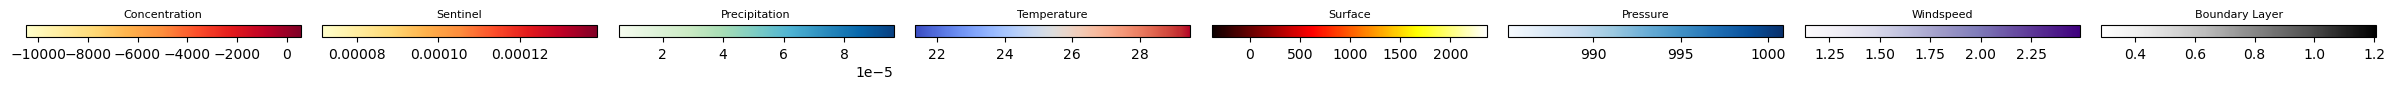

In [19]:
import matplotlib.pyplot as plt
import matplotlib as mpl

# Cleaning
summary = summary.loc[:, ~summary.columns.duplicated()]
summary.columns.name = None
summary = summary.round(10)

# Column grouping by keyword
cols_concentration = [c for c in summary.columns if "Concentration" in c]
cols_sentinel      = [c for c in summary.columns if "Sentinel" in c]
cols_precipitacion = [c for c in summary.columns if "Precipitation" in c]
cols_temperature   = [c for c in summary.columns if "Temperature" in c]
cols_pressure      = [c for c in summary.columns if "Pressure" in c]
cols_wind          = [c for c in summary.columns if "Windspeed" in c]
cols_blh           = [c for c in summary.columns if "Boundary Layer" in c]
cols_surface       = [c for c in summary.columns if "Surface" in c]

# Ensure numeric
for cols in [cols_concentration, cols_sentinel, cols_precipitacion, cols_temperature,
             cols_pressure, cols_wind, cols_blh, cols_surface]:
    for c in cols:
        summary[c] = pd.to_numeric(summary[c], errors="coerce")

def get_col_scale(series, buffer=0.05):
    vals = pd.to_numeric(series, errors="coerce").dropna()
    if len(vals) == 0:
        return (None, None)
    vmin, vmax = vals.min(), vals.max()
    diff = vmax - vmin
    return (vmin - diff*buffer, vmax + diff*buffer)

# Dynamic scales computation for all columns
scales = {}
for c in summary.select_dtypes(include=["float", "int"]).columns:
    vmin, vmax = get_col_scale(summary[c])
    if vmin is not None and vmax is not None:
        scales[c] = (vmin, vmax)

# Palettes
color_map_rules = {
    "Concentration": "YlOrRd",
    "Sentinel": "YlOrRd",
    "Precipitation": "GnBu",
    "Temperature": "coolwarm",
    "Surface": "hot",
    "Pressure": "Blues",
    "Windspeed": "Purples",
    "Boundary Layer": "Greys"
}

# Styling
styled_summary = summary.style

for col in summary.columns:
    cmap = None
    for key, cmap_name in color_map_rules.items():
        if key in col:
            cmap = cmap_name
            break
    if cmap and col in scales:
        vmin, vmax = scales[col]
        styled_summary = styled_summary.background_gradient(
            subset=[col], cmap=cmap, vmin=vmin, vmax=vmax
        )

styled_summary = (
    styled_summary
    .set_properties(**{
        "text-align": "center",
        "font-family": "Segoe UI, sans-serif",
        "font-size": "10pt",
        "border": "1px solid #ddd",
        "padding": "3px"
    })
    .format(precision=6)
)

display(styled_summary)

# Legends
legend_data = {}
for key, cmap_name in color_map_rules.items():
    cols = [c for c in summary.columns if key in c and c in scales]
    if cols:
        vmins = [scales[c][0] for c in cols if scales[c][0] is not None]
        vmaxs = [scales[c][1] for c in cols if scales[c][1] is not None]
        if vmins and vmaxs:
            legend_data[key] = (cmap_name, min(vmins), max(vmaxs))

fig, axes = plt.subplots(1, len(legend_data), figsize=(3*len(legend_data), 1))
if len(legend_data) == 1:
    axes = [axes]

for ax, (label, (cmap_name, vmin, vmax)) in zip(axes, legend_data.items()):
    if vmin is not None and vmax is not None and vmin != vmax:
        norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
        cmap = mpl.cm.get_cmap(cmap_name)
        mpl.colorbar.ColorbarBase(ax, cmap=cmap, norm=norm, orientation="horizontal")
    ax.set_title(label, fontsize=8)

plt.tight_layout()
plt.show()

## Visualization of data WITHOUT NaN

 Cleaning summary:
   • NaN rows removed: 0
   • Rows removed for negative concentrations: 13 (20 total negative values)
   • Final dataset size: 107 rows × 23 columns



,Date,Province,ID Sensor,Latitude,Longitude,Pollutant,"Previous Mean Concentration (Ossidi di Azoto, µg/m³)","Current Mean Concentration (Ossidi di Azoto, µg/m³)",Sentinel 5P Concentration Ossidi di Azoto (mol/m²),Previous Temperature (°C),Current Temperature (°C),Previous Pressure (hPa),Current Pressure (hPa),Previous Total Precipitation (mm),Current Total Precipitation (mm),Previous Windspeed (m/s),Current Windspeed (m/s),Previous Surface Solar Radiation (kJ/m²),Current Surface Solar Radiation (kJ/m²),Previous Surface Thermal Radiation (kJ/m²),Current Surface Thermal Radiation (kJ/m²),Previous Boundary Layer Height [km],Current Boundary Layer Height [km]
0,2025-06-01,MI,6276,45.396198,9.282699,Ossidi di Azoto,26.250000,18.433333,0.000107,23.326060,29.438481,1000.203788,999.474281,0.000015,0.000006,1.386588,2.004210,417.160405,2084.041304,-172.732683,-337.030282,0.355858,1.177786
1,2025-06-01,MI,6288,45.548521,8.847327,Ossidi di Azoto,15.333333,6.000000,0.000109,21.629554,28.269936,986.294019,985.801906,0.000092,0.000017,1.213138,1.548476,420.029075,2306.964800,-135.690235,-365.664971,0.314967,1.033387
2,2025-06-01,MI,6300,45.547597,9.166983,Ossidi di Azoto,23.425000,13.366667,0.000136,22.349484,28.633550,988.408241,987.869134,0.000068,0.000016,1.259149,1.733477,395.779545,2168.375273,-146.985999,-345.452585,0.309079,1.072049
3,2025-06-01,MI,6320,45.443860,9.167945,Ossidi di Azoto,32.350000,12.700000,0.000106,22.978763,29.216975,996.926385,996.260631,0.000031,0.000012,1.404927,1.876858,411.854974,2133.773699,-160.234734,-341.318897,0.351922,1.139189
4,2025-06-01,MI,6324,45.483632,9.327362,Ossidi di Azoto,16.375000,7.166667,0.000112,23.062826,29.141623,996.002742,995.323768,0.000020,0.000012,1.340018,2.038341,403.958601,2097.359512,-166.335726,-337.407088,0.320442,1.128354
5,2025-06-01,MI,6326,45.462421,8.880214,Ossidi di Azoto,19.791667,5.100000,0.000099,22.124429,28.712525,991.340427,990.756891,0.000045,0.000018,1.407702,1.778714,418.916552,2263.923505,-144.032726,-358.843451,0.354138,1.086556
6,2025-06-01,MI,6328,45.496319,9.190934,Ossidi di Azoto,48.666667,32.366667,0.000112,22.886711,29.122715,995.662715,995.020811,0.000033,0.000013,1.323954,1.808868,406.995365,2139.668962,-157.214438,-342.180579,0.327099,1.112198
7,2025-06-01,MI,6338,45.281964,8.988576,Ossidi di Azoto,18.841667,9.233333,0.000118,23.066098,29.369869,999.408650,998.697300,0.000033,0.000015,1.888904,2.236339,422.127612,2148.281146,-162.347731,-342.236557,0.444041,1.199289
8,2025-06-01,MI,6346,45.523429,9.044602,Ossidi di Azoto,35.741667,10.566667,0.000117,22.319846,28.716564,989.319860,988.772556,0.000059,0.000022,1.363808,1.662735,404.522413,2205.045475,-142.668082,-347.109262,0.333594,1.085881
9,2025-06-01,MI,6354,45.470501,9.197461,Ossidi di Azoto,20.633333,13.133333,0.000112,22.982798,29.202248,996.806202,996.145054,0.000029,0.000011,1.348106,1.851293,409.430980,2129.105677,-160.266171,-341.305503,0.336845,1.127108


C:\Users\Administrador\AppData\Local\Temp\ipykernel_1444\2940035130.py:123: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = mpl.cm.get_cmap(cmap_name)


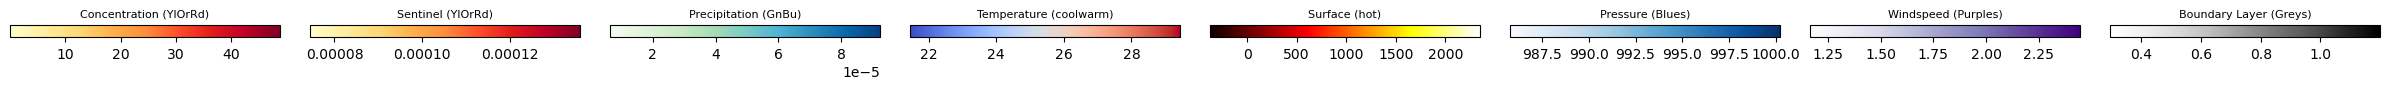

In [20]:
# Cleaning
summary = summary.loc[:, ~summary.columns.duplicated()]
summary.columns.name = None
summary = summary.replace(["None", "none", "NaN", "nan", ""], np.nan)
summary = summary.round(10)

# Convert columns to numeric when possible
for col in summary.columns:
    try:
        summary[col] = pd.to_numeric(summary[col])
    except (ValueError, TypeError):
        pass

# Count and drop NaN rows
nan_before = len(summary)
summary = summary.dropna(how="all").reset_index(drop=True)
nan_removed = nan_before - len(summary)

# Dynamic Selection by keyword 
cols_concentration = [c for c in summary.columns if "Concentration" in c]
cols_sentinel      = [c for c in summary.columns if "Sentinel" in c]
cols_precipitacion = [c for c in summary.columns if "Precipitation" in c]
cols_temperature   = [c for c in summary.columns if "Temperature" in c]
cols_pressure      = [c for c in summary.columns if "Pressure" in c]
cols_wind          = [c for c in summary.columns if "Windspeed" in c]
cols_blh           = [c for c in summary.columns if "Boundary Layer" in c]
cols_surface       = [c for c in summary.columns if "Surface" in c]

# Negative values removal for concentration columns only
neg_before = len(summary)
if cols_concentration:
    neg_count = (summary[cols_concentration] < 0).sum().sum()
    summary = summary[(summary[cols_concentration] >= 0).all(axis=1)]
    neg_removed = neg_before - len(summary)
else:
    neg_count = 0
    neg_removed = 0

#  Cleaning summary printout 
print(f" Cleaning summary:")
print(f"   • NaN rows removed: {nan_removed}")
print(f"   • Rows removed for negative concentrations: {neg_removed} ({int(neg_count)} total negative values)")
print(f"   • Final dataset size: {len(summary)} rows × {len(summary.columns)} columns\n")

# Function for dynamic min/max per column
def get_col_scale(series, buffer=0.05):
    vals = pd.to_numeric(series, errors="coerce").dropna()
    if len(vals) == 0:
        return (None, None)
    vmin, vmax = vals.min(), vals.max()
    diff = vmax - vmin
    return (vmin - diff * buffer, vmax + diff * buffer)

# Compute dynamic scales per column
scales = {}
for c in summary.select_dtypes(include=["float", "int"]).columns:
    vmin, vmax = get_col_scale(summary[c])
    if vmin is not None and vmax is not None:
        scales[c] = (vmin, vmax)

# Palettes
color_map_rules = {
    "Concentration": "YlOrRd",
    "Sentinel": "YlOrRd",
    "Precipitation": "GnBu",
    "Temperature": "coolwarm",
    "Surface": "hot",
    "Pressure": "Blues",
    "Windspeed": "Purples",
    "Boundary Layer": "Greys"
}

# Dynamic styling
styled_summary = summary.style
for col in summary.columns:
    cmap = None
    for key, cmap_name in color_map_rules.items():
        if key in col:
            cmap = cmap_name
            break
    if cmap and col in scales:
        vmin, vmax = scales[col]
        styled_summary = styled_summary.background_gradient(
            subset=[col], cmap=cmap, vmin=vmin, vmax=vmax
        )

# Global style
styled_summary = (
    styled_summary
    .set_properties(**{
        "text-align": "center",
        "font-family": "Segoe UI, sans-serif",
        "font-size": "10pt",
        "border": "1px solid #ddd",
        "padding": "3px"
    })
    .format(precision=6)
)

display(styled_summary)

# Legend
color_maps = {}
for key, cmap_name in color_map_rules.items():
    cols = [c for c in summary.columns if key in c]
    if cols:
        vmin = summary[cols].min().min()
        vmax = summary[cols].max().max()
        color_maps[f"{key} ({cmap_name})"] = (cmap_name, vmin, vmax)

fig, axes = plt.subplots(1, len(color_maps), figsize=(3 * len(color_maps), 1))
if len(color_maps) == 1:
    axes = [axes]

for ax, (label, (cmap_name, vmin, vmax)) in zip(axes, color_maps.items()):
    if pd.notna(vmin) and pd.notna(vmax) and vmin != vmax:
        norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
        cmap = mpl.cm.get_cmap(cmap_name)
        mpl.colorbar.ColorbarBase(ax, cmap=cmap, norm=norm, orientation="horizontal")
    ax.set_title(label, fontsize=8)

plt.tight_layout()
plt.show()


In [21]:
start_str = pd.to_datetime(cfg["start_date"]).strftime("%Y%m%d")
end_str = pd.to_datetime(cfg["end_date"]).strftime("%Y%m%d")

# Folder creation
output_dir = f"results/ARPA_ERA_S5P-{start_str}_to_{end_str}"
os.makedirs(output_dir, exist_ok=True)

# CSV file output
output_path = os.path.join(output_dir, "summary_clean.csv")


summary.to_csv(output_path, index=False)

print(f"\nFile saved in:\n{output_path}\n")



File saved in:
results/ARPA_ERA_S5P-20250601_to_20250608\summary_clean.csv

